This notebook trains and tests the HyMoLAP_GR4J_CNN model in the L0123001 catchment. It uses the ReLU activation function and is compiled with the Adam optimizer.

In [9]:
import pandas as pd
from pandas import read_csv
import numpy as np
from numpy import concatenate
import math
from math import sqrt
import random
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from matplotlib import pylab as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D
from keras.optimizers import Adam

from tensorflow.keras.layers import Flatten

import joblib
from google.colab import files
import matplotlib.dates as mdates


In [10]:
import tensorflow as tf

seed = 413
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# To enforce determinism on operations
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
daily = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Alone/airGR_L0123001.csv')

daily.head()

,Unnamed: 0,DatesR,P,T,E,Qls,Qmm
0,1,1984-01-01,4.1,0.5,0.2,2640.0,0.6336
1,2,1984-01-02,15.9,0.2,0.2,3440.0,0.8256
2,3,1984-01-03,0.8,0.9,0.3,12200.0,2.9280
3,4,1984-01-04,0.0,0.5,0.3,7600.0,1.8240
4,5,1984-01-05,0.0,-1.6,0.1,6250.0,1.5000


In [13]:
#Calibration data
discharge = daily.iloc[5114:7671, -1].to_numpy()
plui = daily.iloc[5114:7671, 2].to_numpy()
etp = daily.iloc[5114:7671, 4].to_numpy()

#Validation data
discharge1 = daily.iloc[7671:8766, -1].to_numpy()
plui1 = daily.iloc[7671:8766, 2].to_numpy()
etp1 = daily.iloc[7671:8766, 4].to_numpy()

In [14]:
#NSE, RMSE, R2
def nash_sutcliffe_efficiency(observed, simulated):
    obs_mean = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - obs_mean) ** 2)

    nse = 1 - (numerator / denominator)
    return nse

def calculate_rmse(observed, predicted):

    rmse = np.sqrt(np.mean((observed - predicted)**2))
    return rmse

def calculate_r2(observed, predicted):

    mean_observed = np.mean(observed)
    mean_predicted = np.mean(predicted)

    numerator = np.sum((observed - mean_observed) * (predicted - mean_predicted))
    denominator = np.sqrt(np.sum((observed - mean_observed)**2)) * np.sqrt(np.sum((predicted - mean_predicted)**2))

    r2 = (numerator / denominator)**2
    return r2


GR4J-HyMoLAP

In [15]:
#Percolation

def Percolation(Pn, En, X1):
   n = len(Pn)
   S = np.zeros(n)
   S[0] =  Pn[0]

   Perc = np.zeros(n)
   ratio = (4.0 / 9.0) * (S[0] / X1)
   Perc[0] = S[0] * (1 - (1 + ratio**4) ** (-0.25))

   Pr = np.zeros(n)
   Pr[0] = Perc[0] + Pn[0]

   for i in range(1, n):
        temp = (S[i-1] / X1) ** 2
        frac = Pn[i] / X1
        Ps = X1 * (1 - temp) * np.tanh(frac) / (1 + (S[i-1] / X1) * np.tanh(frac))

        frac = En[i] / X1
        Es = S[i-1] * (2 - S[i-1] / X1) * np.tanh(frac) / (1 + (1 - S[i-1] / X1) * np.tanh(frac))

        S[i] = S[i-1] + Ps - Es

        ratio = (4.0 / 9.0) * (S[i] / X1)
        Perc[i] = S[i] * (1 - (1 + ratio**4) ** (-0.25))

        Pr[i] = Perc[i] + Pn[i] - Ps

   return Perc

In [16]:
#  model calibration : Here we chose the below ranges and then the optimal values found were:  mu = 0.9756486900089809, lambda_ = 6.261137845168766, X1 = 99.62821160899779,
# following the same calibration process with the HyMoLAP above.
Pn = plui - etp
Pn[Pn < 0] = 0

En = etp - plui
En[En < 0] = 0

nse = -100
Qsim = np.zeros(len(discharge))
Qsim[0] = discharge[0]
Q1 = np.zeros(len(discharge))

for pp in range(1):
      mu = 0.9756486900089809 #(1.4 - 0.5) * np.random.rand() + 0.5
      lambda_ = 6.261137845168766 #(10 - 1) * np.random.rand() + 1
      X1 = 99.62821160899779 #(100 - 70) * np.random.rand() + 70

      Perc = Percolation(Pn, En, X1)

      for k in range(0, len(discharge)-1):

          Qsim[k+1] = Qsim[k] - (mu/lambda_) * Qsim[k]**(2*mu-1) +  (1/lambda_) * Perc[k] * Pn[k]

      #Nsh criteria
      nsee =  nash_sutcliffe_efficiency(discharge[1:], Qsim[1:])
      if nsee > nse:
          nse = nsee
          mu1 = mu
          lambda1 = lambda_
          X11 = X1
          GR4J_HyM = Qsim.copy()


print(nse)

0.6708540197644917


In [17]:
print(mu1)
print(lambda1)
print(X11)

0.9756486900089809
6.261137845168766
99.62821160899779


In [18]:
print('nashe=',nash_sutcliffe_efficiency(discharge[1:],  GR4J_HyM[1:]))
print('rmse=',calculate_rmse(discharge[1:],  GR4J_HyM[1:]))
print('r2=',calculate_r2(discharge[1:],  GR4J_HyM[1:]))

nashe= 0.6708540197644917
rmse= 0.8935489568574768
r2= 0.7273633888404886


Validation

In [19]:
Pn1 = plui1 - etp1
Pn1[Pn1 < 0] = 0

En1 = etp1 - plui1
En1[En1 < 0] = 0

In [21]:
# Simulation
size = len(discharge1)
Perc1 = Percolation(Pn1, En1, X11)

#EQUATION
Qval = np.zeros(size)
Qval[0] = discharge1[0]

for k in range(0, size-1):

    Qval[k+1] = Qval[k] - (mu1/lambda1) * Qval[k]**(2*mu1-1) +  (1/lambda1) * Perc1[k] * Pn1[k]

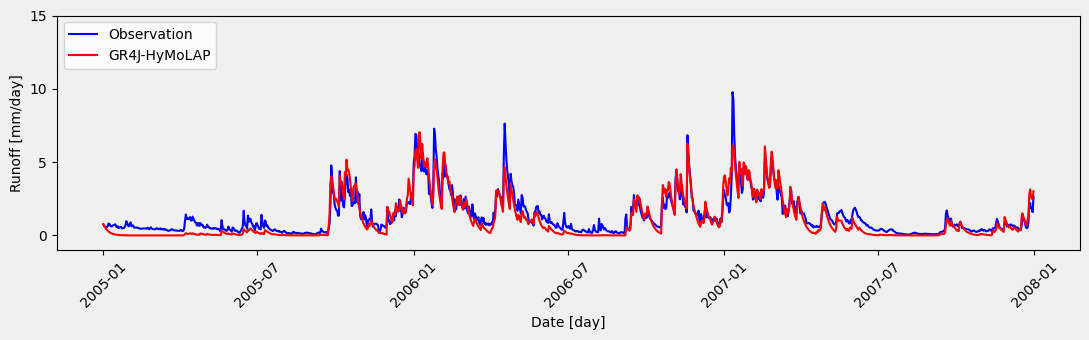

In [22]:
# Generate dates
time1 = np.datetime64('2005-01-01')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(11., 3.5))

# Background color
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Plot observed and simulated discharges
ax.plot(time, discharge1, 'b', label='Observation', linewidth=1.5)
#ax.plot(time, Qval_HyM, 'green', label='HyMoLAP', linewidth=1.5)
ax.plot(time, Qval, 'red', label='GR4J-HyMoLAP', linewidth=1.5)
#ax.plot(time, mean_trajectory1, 'red', label='GR4J-HyMoLAP', linewidth=1.5)

# X-axis parameters (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45)
ax.set_xlabel('Date [day]')

# Y-axis parameters
ax.set_ylabel('Runoff [mm/day]')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(-1, 15)
ax.set_yticks(np.arange(0, 16, 5))

# Add legend
ax.legend(loc='upper left')

# Show grid
#plt.grid(True)

# Avoid overlaps
plt.tight_layout()

# Save figure
plt.savefig("hyM_save_val2.jpeg", format='jpeg', dpi=500)

# Save figure again with different name and dpi
plt.savefig("airGR_L0123001_GR4J-HyMoLAP.jpeg", format='jpeg', dpi=700)

#files.download("airGR_L0123001_GR4J-HyMoLAP.jpeg")

# Display figure
plt.show()


In [23]:
#Performance
nse_value = nash_sutcliffe_efficiency(discharge1, Qval)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge1, Qval)
print('rmse=', rmse)

r2 = calculate_r2(discharge1, Qval)
print('r2=', r2)

Nash-Sutcliffe Efficiency (NSE): 0.8324726667854867
rmse= 0.5458726450387722
r2= 0.8806127591849476


Hybrid HyMoLAP_GR4J_CNN.

In [24]:
def split_train_test(values, n_train_hours = 1460):
    # Split the data into train (use values before n_train_hours) and test sets (use values after n_train_hours)
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features] required for LSTM
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    return train_X, train_y, test_X, test_y

In [25]:
def history_and_horizon_sequencing(df, n_history, n_horizon, target='debits'):
    # Separate inputs (e.g., precipitation, PET) from targets (e.g., discharge)
    input_columns = [col for col in df.columns if col != target]
    df_inputs = df[input_columns]
    df_target = df[target].to_frame()

    # History: past sequences (t-n, ... t-1) for inputs (e.g., precipitation, ETP)
    stack_history = []
    for i in range(n_history, 0, -1):
        df_i = df_inputs.shift(i)
        df_i.columns = [f'{col}_t-{i}' for col in df_i.columns]
        stack_history.append(df_i)

    # Present: t for inputs
    df_t = df_inputs.copy()
    df_t.columns = [f'{col}_t' for col in df_t.columns]

    # Horizon: future sequences (t+1, ... t+n) for targets (e.g., discharge)
    stack_horizon = []
    for j in range(0, n_horizon):
        df_j = df_target.shift(-j)
        df_j.columns = [f'{col}_t+{j}' for col in df_j.columns]
        stack_horizon.append(df_j)

    # Return the concatenated DataFrame: past + present + future (inputs and targets)
    return pd.concat(stack_history + [df_t] + stack_horizon, axis=1)

In [26]:
# Create DataFrame for training (calibration)
data_train = pd.DataFrame({
    'perc': Perc,
    'Qsim': GR4J_HyM,
    'prec': plui,
    'pet': etp,

    'target': discharge
})

# Create DataFrame for validation (test)
data_test = pd.DataFrame({
    'perc': Perc1,
    'Qsim': Qval,
    'prec': plui1,
    'pet': etp1,

    'target': discharge1
})

# Concatenate the two DataFrames (calibration + validation)
data = pd.concat([data_train, data_test], ignore_index=True)


In [27]:
#Include look_back
look_back = 0
horizon = 1     # To correspond to the same day (t) as the inputs

data_Xy = history_and_horizon_sequencing(data, look_back, horizon, target='target')
data_Xy.dropna(inplace=True)


#split data
train_X, train_y, test_X, test_y = split_train_test(data_Xy.values, 2557)


(2557, 1, 4) (2557,) (1095, 1, 4) (1095,)


In [28]:
data_Xy

,perc_t,Qsim_t,prec_t,pet_t,target_t+0
0,5.102629e-09,0.314400,2.4,0.2,0.31440
1,2.403751e-08,0.262568,1.3,0.5,0.31440
2,7.547647e-06,0.218900,6.9,0.4,0.31440
3,2.405377e-05,0.182178,2.6,0.1,0.29040
4,1.973808e-04,0.151345,6.6,0.2,0.29040
...,...,...,...,...,...
3647,6.844246e-01,3.139731,0.3,0.0,2.22240
3648,6.924263e-01,2.709789,1.9,0.1,1.83816
3649,7.057462e-01,2.506608,3.3,0.2,1.84512
3650,7.359943e-01,2.482536,8.0,0.4,1.58712


In [29]:
discharge[2]

np.float64(0.3144)

In [30]:
def build_1d_cnn_model(input_shape, nb_filters=64, kernel_size=1, pool_size=1):
    '''
    Build a 1D ConvNet model with two Conv1D layers
    '''
    model = Sequential()

    # First Conv1D layer
    model.add(Conv1D(filters=nb_filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=pool_size))

    # Flatten before Dense layer
    model.add(Flatten())

    # Output Dense layer
    model.add(Dense(units=1))

    # Compile the model
    model.compile(loss='mae', optimizer='adam')

    return model


def train_model(model, train_X, train_y, test_X, test_y, epochs=42, batch_size=64, verbose=0):
    '''
    Generic function to train the model
    '''
    history = model.fit(train_X, train_y,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(test_X, test_y),
                        verbose=verbose,
                        shuffle=True)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()


Simulation with Scaling data

In [31]:
# Normalize features
values = data_Xy.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

# Create train/tests datasets from scaled_data
scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y = split_train_test(scaled_values, 2557)

(2557, 1, 4) (2557,) (1095, 1, 4) (1095,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


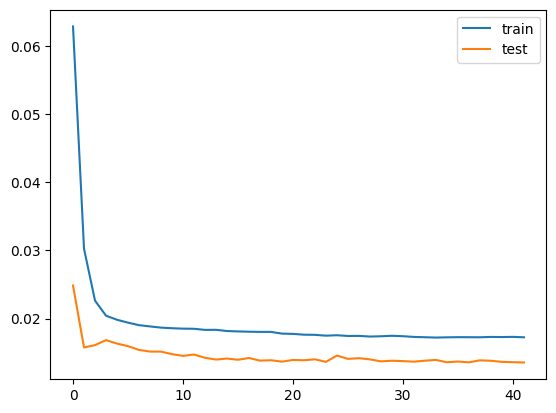

In [32]:
# Build and train the model
input_shape=(scaled_train_X.shape[1], scaled_train_X.shape[2])
# Build and train the model using the build_lstm_model (new instance name lstm_model_scaled)
Con_lstm_model_scaled = build_1d_cnn_model(input_shape, nb_filters=64, kernel_size=1, pool_size=1)
# Train the new model using train_model method as previousely using the new scaled data
train_model(Con_lstm_model_scaled, scaled_train_X, scaled_train_y, scaled_test_X, scaled_test_y)

In [33]:
# invert scaling for forecast
def invert_scaling(scaled_X, scaled_yhat):
  scaled_tX = scaled_X.reshape((scaled_X.shape[0], scaled_X.shape[2]))
  Xyat = concatenate((scaled_tX, scaled_yhat.reshape(-1,1)), axis=1)
  inv_Xyat = scaler.inverse_transform(Xyat)
  return inv_Xyat[:,-1]


In [34]:
# make a prediction on train
sca_train_pred_yhat = Con_lstm_model_scaled.predict(scaled_train_X)
#
sca_inv_yhat = invert_scaling(scaled_train_X, sca_train_pred_yhat)

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [35]:
# Training Performance evaluation
sca_train_pred_flat = sca_inv_yhat.flatten()

nse_value = nash_sutcliffe_efficiency(discharge[1:], sca_train_pred_flat[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge[1:], sca_train_pred_flat[1:])
print('RMSE =', rmse)

r2 = calculate_r2(discharge[1:], sca_train_pred_flat[1:])
print('R² =', r2)

Nash-Sutcliffe Efficiency (NSE): 0.8391915649033294
RMSE = 0.6245662138384483
R² = 0.8437362305212133


In [36]:
# make a prediction on test
sca_test_pred_yhat = Con_lstm_model_scaled.predict(scaled_test_X)
#
sca_inv_yhat = invert_scaling(scaled_test_X, sca_test_pred_yhat)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [37]:
# Validation Performance evaluation
sca_test_pred_flat = sca_inv_yhat.flatten()

nse_value = nash_sutcliffe_efficiency(discharge1[1:], sca_test_pred_flat[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge1[1:], sca_test_pred_flat[1:])
print('RMSE =', rmse)

r2 = calculate_r2(discharge1[1:], sca_test_pred_flat[1:])
print('R² =', r2)

Nash-Sutcliffe Efficiency (NSE): 0.8844676480828987
RMSE = 0.4534857899318124
R² = 0.884500751224897


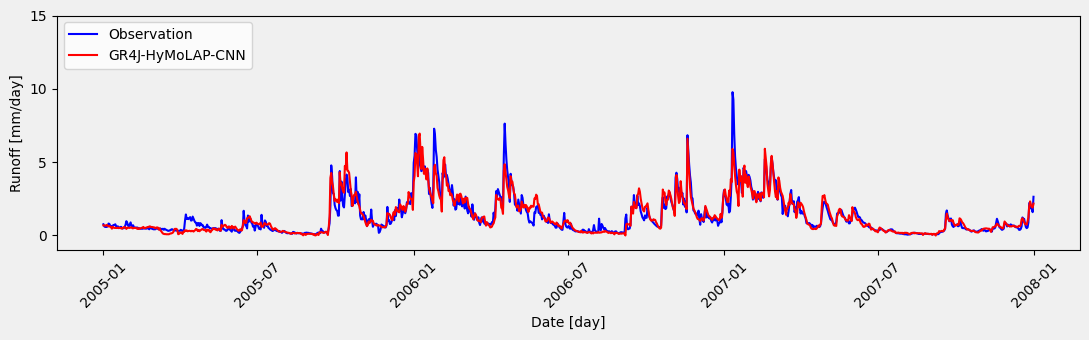

In [38]:
# Generate dates from 2005-01-01 to 2007-12-31
time1 = np.datetime64('2005-01-01')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(11., 3.5))

# Background color
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Plot observed and simulated runoff
ax.plot(time, discharge1, 'b', label='Observation')
#ax.plot(time, Qval_HyM, 'green', label='HyMoLAP', linewidth=1.5)
ax.plot(time, sca_test_pred_flat, 'red', label='GR4J-HyMoLAP-CNN')
#ax.plot(time, mean_trajectory1, 'red', label='GR4J-HyMoLAP', linewidth=1.5)

# Configure x-axis (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45)
ax.set_xlabel('Date [day]')

# Configure y-axis
ax.set_ylabel('Runoff [mm/day]')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(-1, 15)
ax.set_yticks(np.arange(0, 16, 5))

# Add legend
ax.legend(loc='upper left')

# Show grid (commented out)
#plt.grid(True)

# Prevent overlap
plt.tight_layout()

# Save figure as JPEG with high resolution
plt.savefig("airGR_L0123001_GR4J-HyMoLAP-CNN.jpeg", format='jpeg', dpi=700)

# Uncomment below if you want to download the image (in Colab)
# files.download("airGR_L0123001_GR4J-HyMoLAP-CNN.jpeg")

# Show the plot
plt.show()
